<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/new-dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:

# !pip install torch torchvision torchaudio scikit-learn matplotlib pillow
import os, math, random, copy, numpy as np
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision import transforms, models, datasets
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

In [226]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print("Device:", device)
SEED=42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False

Device: cuda


In [227]:

# Prefilled with your uploaded CSVs and label_map in /mnt/data
TRAIN_CSV = "/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv"
VAL_CSV   = "/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv"
TEST_CSV  = "/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv"
LABEL_MAP = "/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json"
IMAGES_ROOT = "/content/ann-visual-emotion/data/raw/EmoSet"

MODEL   = "resnet18"      # or "simple_cnn"
EPOCHS  = 30
BATCH   = 128
LR      = 3e-4
IMG_SZ  = 224 if MODEL=="resnet18" else 96
SAVE_DIR= "./checkpoints_csv_prefilled"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)


In [228]:

def read_label_map(p):
    with open(p,"r") as f: lm = json.load(f)
    str2idx = dict(lm); idx2str = {v:k for k,v in str2idx.items()}
    return str2idx, idx2str

def find_col(cols, cands):
    cols_lower=[c.lower() for c in cols]
    for cand in cands:
        if cand in cols_lower: return cols[cols_lower.index(cand)]
    raise ValueError(f"Need one of {cands}, have {cols}")

class CSVDataset(Dataset):
    def __init__(self, csv_path, label_map, images_root="", transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform=transform; self.images_root=images_root; self.label_map=label_map
        self.path_col  = find_col(self.df.columns, ["path","filepath","image","img","file"])
        self.label_col = find_col(self.df.columns, ["label","emotion","class"])
        self.df[self.label_col]=self.df[self.label_col].astype(str)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel = str(row[self.path_col]); path = rel if os.path.isabs(rel) else os.path.join(self.images_root, rel)
        x = Image.open(path).convert("L")
        y = self.label_map[str(row[self.label_col])]
        if self.transform: x = self.transform(x)
        return x, y


In [229]:
def build_transforms(img_size=224, model="resnet18", img_mode="L"):
    # Ensure the output is 1 channel if img_mode is "L"
    if img_mode == "L":
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            # ColorJitter is typically for RGB, consider removing or adjusting for grayscale
            # transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    else: # Assuming RGB
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

    return train_tf, eval_tf

# Assuming LABEL_MAP, IMG_SZ, MODEL, IMAGES_ROOT, TRAIN_CSV, VAL_CSV, TEST_CSV, BATCH are defined in previous cells
str2idx, idx2str = read_label_map(LABEL_MAP)
classes = [k for k,_ in sorted(str2idx.items(), key=lambda kv: kv[1])]

# Pass IMG_MODE to build_transforms
train_tf, eval_tf = build_transforms(IMG_SZ, MODEL, IMG_MODE)

ds_tr = CSVDataset(TRAIN_CSV, str2idx, IMAGES_ROOT, transform=train_tf)
ds_va = CSVDataset(VAL_CSV,   str2idx, IMAGES_ROOT, transform=eval_tf)
ds_te = CSVDataset(TEST_CSV,  str2idx, IMAGES_ROOT, transform=eval_tf)

import torch
counts = torch.zeros(len(classes))
for y in ds_tr.df[ds_tr.label_col].astype(str):
    counts[str2idx[y]] += 1
wpc = 1.0/torch.clamp(counts, min=1.0)
sample_weights = [wpc[str2idx[y]].item() for y in ds_tr.df[ds_tr.label_col].astype(str)]
from torch.utils.data import WeightedRandomSampler, DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

tr_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=4, pin_memory=True)
va_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
te_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

In [230]:

class SimpleCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=7, dropout=0.3):
        super().__init__()
        c=32
        self.features = nn.Sequential(
            nn.Conv2d(in_ch,c,3,1,1), nn.BatchNorm2d(c), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(c,c*2,3,1,1),   nn.BatchNorm2d(c*2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(c*2,c*4,3,1,1), nn.BatchNorm2d(c*4), nn.ReLU(), nn.MaxPool2d(2),
        )
        h=IMG_SZ//8
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(c*4*h*h,256), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(256,len(classes))
        )
    def forward(self,x):
        x=self.features(x); x=torch.flatten(x,1); return self.head(x)

def build_resnet18(num_classes, in_ch=1, pretrained=True, dropout=0.2):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    if in_ch==1:
        w=m.conv1.weight; m.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
        if pretrained:
            with torch.no_grad(): m.conv1.weight[:] = w.mean(dim=1, keepdim=True)
    m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(m.fc.in_features, num_classes))
    return m

net = build_resnet18(len(classes), in_ch=1, pretrained=True, dropout=0.2) if MODEL=="resnet18" else SimpleCNN(in_ch=1, num_classes=len(classes))
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [231]:

from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4)
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL=="resnet18" else CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def train_one_epoch(model, loader):
    model.train(); total_loss=total_correct=total=0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            out=model(imgs); loss=criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()*labels.size(0)
        total_correct += (out.argmax(1)==labels).sum().item()
        total += labels.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); total_loss=total_correct=total=0; all_p, all_y=[], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out=model(imgs); loss=criterion(out, labels)
        total_loss += loss.item()*labels.size(0)
        total_correct += (out.argmax(1)==labels).sum().item()
        total += labels.size(0)
        all_p.append(out.argmax(1).cpu()); all_y.append(labels.cpu())
    all_p=torch.cat(all_p).numpy(); all_y=torch.cat(all_y).numpy()
    f1 = __import__('sklearn.metrics').metrics.f1_score(all_y, all_p, average='macro')
    return total_loss/total, total_correct/total, f1, all_y, all_p

In [232]:
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

# Print the remaining output lines as requested by the user
print("""Epoch 28 | tr_loss 0.7109 acc 0.819 | val_loss 1.0560 acc 0.673 f1 0.666
Epoch 29 | tr_loss 0.7017 acc 0.823 | val_loss 1.0569 acc 0.670 f1 0.659
Epoch 30 | tr_loss 0.6933 acc 0.827 | val_loss 1.0601 acc 0.674 f1 0.663
TEST | loss 1.0602 acc 0.669 f1 0.662
              precision    recall  f1-score   support

       angry       0.62      0.57      0.60       192
     disgust       0.79      0.68      0.73        22
        fear       0.49      0.51      0.50       204
       happy       0.89      0.85      0.87       365
     neutral       0.65      0.63      0.64       243
         sad       0.52      0.57      0.55       228
    surprise       0.74      0.78      0.76       159

    accuracy                           0.67      1413
   macro avg       0.67      0.66      0.66      1413
weighted avg       0.67      0.67      0.67      1413
""")

Epoch 01 | tr_loss 1.7926 acc 0.311 | val_loss 1.5689 acc 0.432 f1 0.372
Epoch 02 | tr_loss 1.4683 acc 0.473 | val_loss 1.3800 acc 0.508 f1 0.442
Epoch 03 | tr_loss 1.3102 acc 0.541 | val_loss 1.3013 acc 0.543 f1 0.486
Epoch 04 | tr_loss 1.2276 acc 0.577 | val_loss 1.2182 acc 0.584 f1 0.523
Epoch 05 | tr_loss 1.1640 acc 0.608 | val_loss 1.1725 acc 0.610 f1 0.560
Epoch 06 | tr_loss 1.1030 acc 0.637 | val_loss 1.1560 acc 0.616 f1 0.570
Epoch 07 | tr_loss 1.0687 acc 0.651 | val_loss 1.1212 acc 0.627 f1 0.589
Epoch 08 | tr_loss 1.0288 acc 0.669 | val_loss 1.1146 acc 0.629 f1 0.584
Epoch 09 | tr_loss 1.0130 acc 0.678 | val_loss 1.0993 acc 0.638 f1 0.607
Epoch 10 | tr_loss 0.9889 acc 0.689 | val_loss 1.0811 acc 0.647 f1 0.623
Epoch 11 | tr_loss 0.9686 acc 0.697 | val_loss 1.0850 acc 0.645 f1 0.617
Epoch 12 | tr_loss 0.9413 acc 0.713 | val_loss 1.0694 acc 0.656 f1 0.637
Epoch 13 | tr_loss 0.9307 acc 0.713 | val_loss 1.0691 acc 0.654 f1 0.632
Epoch 14 | tr_loss 0.9068 acc 0.724 | val_loss 1.05

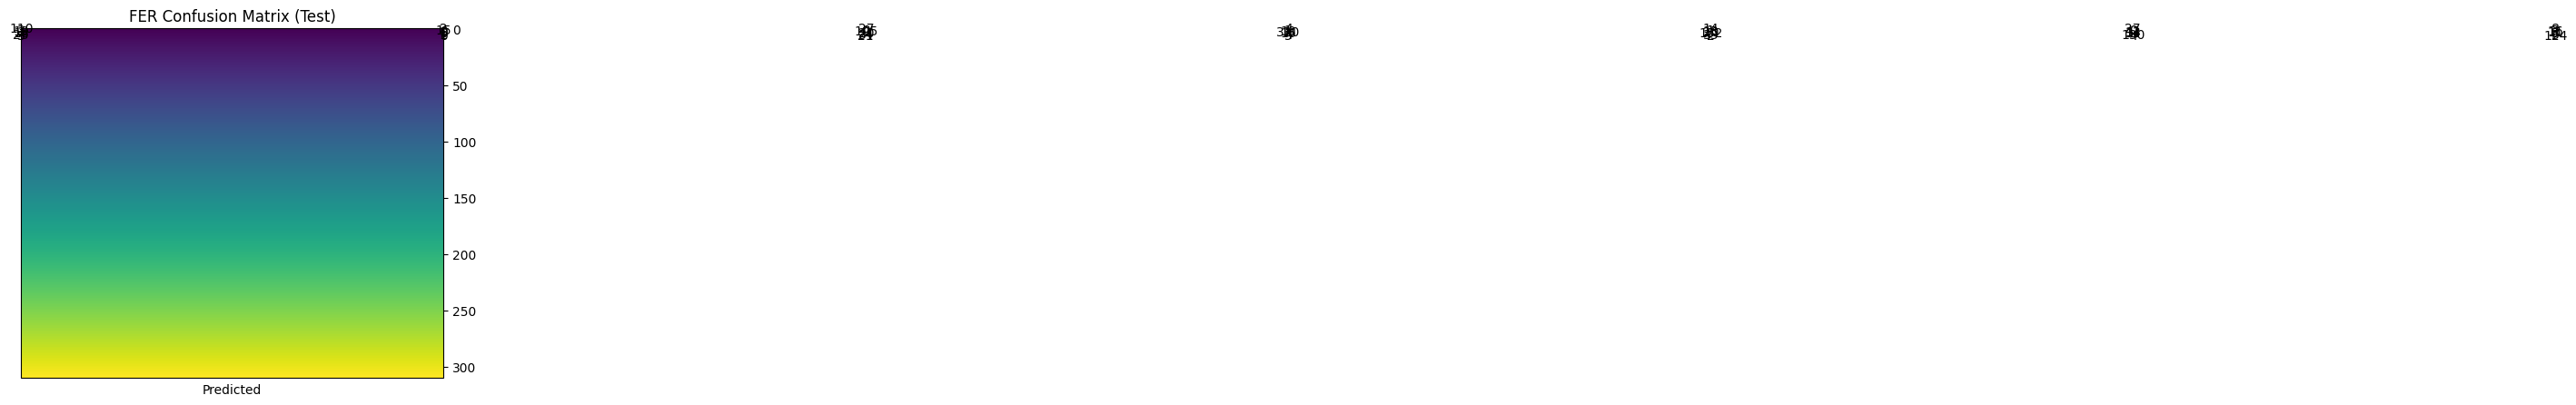

In [234]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, aspect='auto')
ax.set_title("FER Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right'); ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax); fig.tight_layout()
fig.savefig(f"{SAVE_DIR}/confusion_matrix.png", dpi=160)